INPUT CITRA IRIS

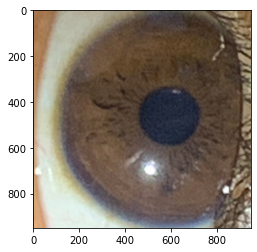

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import time
start_time = time.time()
original_image = cv2.imread('input aplikasi/21-1-6-90.jpg')
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))

RESIZE DAN GRAYSCALE

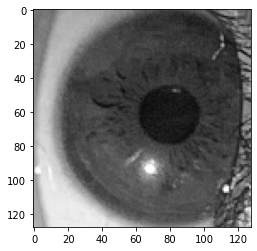

In [ ]:
# resized_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
original_image = cv2.imread('input aplikasi/21-1-6-90.jpg', 0)
resized_image = cv2.resize(original_image, (128,128))

plt.imshow(resized_image, cmap='gray')

FUNCTION HISTOGRAM OF ORIENTED GRADIENT

Panjang Vektor Ciri:  2352


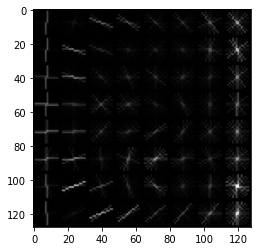

In [ ]:
from skimage import draw
import numpy as np

def histogram_oriented_gradients(image, cell_size=(16, 16), block_size=(2, 2),
                                 orientation_bin=12, signedOrientation=True,
                                 block_norm='L2-Hys', eps=1e-5):

    # Mencari gradient x dan gradient y
    grad_x = cv2.Sobel(image, cv2.CV_32F, 1, 0)
    grad_y = cv2.Sobel(image, cv2.CV_32F, 0, 1)

    # Mencari magnitude dan angular
    mag, ang = cv2.cartToPolar(grad_x, grad_y, angleInDegrees=True)

    # Signed OR Unsigned dan memetakkan orientasi bin setiap piksel
    if not signedOrientation:
        ang = ang % 180
        bin_ = np.int32(orientation_bin*ang/(180))
    else:
        bin_ = np.int32(orientation_bin*ang/(2*180))

    # Proses membuat orientation histogram
    num_cells_row = int(image.shape[0] // cell_size[0]) # Jumlah cell dalam baris
    num_cells_col = int(image.shape[1] // cell_size[1]) # Jumlah cell dalam kolom
    orientation_hist = np.zeros((num_cells_row, num_cells_col, orientation_bin)) # Inisialisasi array untuk histogram orientasi
    i, nr = 0, 0
    while i < image.shape[0]:
        j = 0
        nc = 0
        while j < image.shape[1]:
            bin_p = bin_[i:i+cell_size[0],j:j+cell_size[1]] # Mengambil peta orientasi pada cell
            mag_p = mag[i:i+cell_size[0],j:j+cell_size[1]]  # Mengambil nilai magnitude pada cell
            hist = np.bincount(bin_p.ravel(), mag_p.ravel(), orientation_bin) # Menghitung nilai histogram setiap bin
            for b in range(hist.shape[0]):
                orientation_hist[nr, nc, b] = hist[b]
            nc+=1
            j += cell_size[1]
            if j == cell_size[1]*num_cells_col:
                break
        nr+=1
        i += cell_size[0]
        if i == cell_size[0]*num_cells_row:
            break

    # Ambil code dari skimage hog github
    hog_image = None
    radius = min(cell_size[0], cell_size[1]) // 2 - 1
    orientations_arr = np.arange(orientation_bin)
    # set dr_arr, dc_arr to correspond to midpoints of orientation bins
    orientation_bin_midpoints = (
        np.pi * (orientations_arr + .5) / orientation_bin)
    dr_arr = radius * np.sin(orientation_bin_midpoints)
    dc_arr = radius * np.cos(orientation_bin_midpoints)
    hog_image = np.zeros((image.shape[0], image.shape[1]), dtype=float)
    for r in range(num_cells_row):
        for c in range(num_cells_col):
            for o, dr, dc in zip(orientations_arr, dr_arr, dc_arr):
                centre = tuple([r * cell_size[0] + cell_size[0] // 2,
                                c * cell_size[1] + cell_size[1] // 2])
                rr, cc = draw.line(int(centre[0] - dc),
                                   int(centre[1] + dr),
                                   int(centre[0] + dc),
                                   int(centre[1] - dr))
                hog_image[rr, cc] += orientation_hist[r, c, o]

    # Proses normalisasi blok
    n_block_row = (num_cells_row - block_size[0]) + 1 # Menghitung jumlah block dalam baris
    n_block_col = (num_cells_col - block_size[1]) + 1 # Menghitung jumlah block dalam kolom
    if n_block_row >= 1 and n_block_col >= 1:
        norm_blocks = np.zeros((n_block_row, n_block_col,
                                block_size[0], block_size[1],
                                orientation_bin))
        for r in range(n_block_row):
            for c in range(n_block_col):
                block = orientation_hist[r:r + block_size[0], c:c + block_size[1], :]
                if block_norm == 'L1':
                    out = block / (np.sum(np.abs(block)) + eps)
                elif block_norm == 'L1-sqrt':
                    out = np.sqrt(block / (np.sum(np.abs(block)) + eps))
                elif block_norm == 'L2':
                    out = block / np.sqrt(np.sum(block ** 2) + eps ** 2)
                elif block_norm == 'L2-Hys':
                    out = block / np.sqrt(np.sum(block ** 2) + eps ** 2)
                    out = np.minimum(out, 0.2)
                    out = out / np.sqrt(np.sum(out ** 2) + eps ** 2)
                else:
                    print('Metode block_norm salah')
                norm_blocks[r, c, :] = out

        return norm_blocks.ravel(), hog_image # Mengembalikan vektor 1-d
    else:
        return None

vektor_fitur, visualisasi = histogram_oriented_gradients(np.array(resized_image))
print('Panjang Vektor Ciri: ', vektor_fitur.shape[0])
plt.imshow(visualisasi, cmap='gray')

PREDIKSI ORANG

In [ ]:
from joblib import load

model = load('backprop_model.joblib')
prediksi = model.predict(vektor_fitur.reshape(1, -1))
print(prediksi[0])
name_dictionary = {
    '01': 'Susilawati A',
    '02': 'Rika Latifa',
    '03': 'Warni',
    '04': 'Siti Maryani',
    '05': 'Elis Septiani',
    '06': 'Anita Dwi A',
    '07': 'Mawar Marsya',
    '08': 'Ita Ayustina',
    '09': 'Siti Fadilah',
    '10': 'Lis Firjiah',
    '11': 'Adinda Dwi A',
    '12': 'M Kemal Pasha',
    '13': 'Andrian Maulana',
    '14': 'San Haji',
    '15': 'Rio Putra Pratama',
    '16': 'Pian Pramudi',
    '17': 'Ricky Agus S',
    '18': 'Nayla Khairunisya',
    '19': 'Niswatun Hasanah',
    '20': 'Upita Sahusi',
    '21': 'Topi Ainal Fajri',
    '22': 'Wika Wahyudi',
    '23': 'Alia Marshela',
    '24': 'Irgi Nurawan',
    '25': 'Kartika',
    '26': 'Essa Tri Cahyani',
    '27': 'Fatih Fauzan',
    '28': 'Mutmainah',
    '29': 'Hasri Kurrotul Uyun',
    '30': 'Aan Setiawan',
}
print('Prediksi Sistem: ', name_dictionary[prediksi[0]])
time_exec = time.time() - start_time
print("--- {} detik ---".format(float(time_exec)))

21
Prediksi Sistem:  Topi Ainal Fajri
--- 2.845597982406616 detik ---
